<a href="https://colab.research.google.com/github/Alenushka2013/ML_for_people_lectures/blob/main/HW_2_4_kNN_Cross_validation_and_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [17]:
!wget https://raw.githubusercontent.com/Alenushka2013/ML_for_people_tasks/refs/heads/main/process_bank_churn.py

--2025-07-14 11:24:38--  https://raw.githubusercontent.com/Alenushka2013/ML_for_people_tasks/refs/heads/main/process_bank_churn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5943 (5.8K) [text/plain]
Saving to: ‘process_bank_churn.py.2’

process_bank_churn. 100%[===================>]   5.80K  --.-KB/s    in 0s      

2025-07-14 11:24:38 (65.7 MB/s) - ‘process_bank_churn.py.2’ saved [5943/5943]



In [18]:
from process_bank_churn import preprocess_data

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

raw_df = pd.read_csv('https://raw.githubusercontent.com/Alenushka2013/Coursera/refs/heads/master/Datasets/bank-customer-churn-prediction.csv', index_col=0)

data = preprocess_data(raw_df, scale_numeric=True)

X_train = data['X_train']
train_targets = data['y_train']
X_val = data['X_val']
val_targets = data['y_val']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [20]:
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [21]:
def auroc_train_and_val(model, X_train, X_val, train_targets, val_targets):

  train_probs = model.predict_proba(X_train)
  val_probs = model.predict_proba(X_val)

  # рахуємо ROC-криві
  fpr_train, tpr_train, _ = roc_curve(train_targets, train_probs[:, 1])
  fpr_val, tpr_val, _ = roc_curve(val_targets, val_probs[:, 1])

  # обчислюємо AUC
  auc_train = roc_auc_score(train_targets, train_probs[:, 1])
  auc_val = roc_auc_score(val_targets, val_probs[:, 1])

  # будуємо графік
  plt.figure(figsize=(8, 6))
  plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.4f})")
  plt.plot(fpr_val, tpr_val, label=f"Validation ROC (AUC = {auc_val:.4f})")
  plt.plot([0, 1], [0, 1], linestyle='--', color='green')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()

In [22]:
# Функція, щоб передбачати  значення і рахувати метрики
def predict_and_plot(model, inputs, targets, name=''):
    pred_prob = model.predict_proba(inputs)
    predict = model.predict(inputs)
    # roc_auc = roc_auc_score(targets, pred_prob[:, 1])
    # print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    confusion_matrix_ = confusion_matrix(targets,predict, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

    # Звіт про класифікацію
    #print(classification_report(targets, predict))

    report = classification_report(targets, predict, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Printing with 3 decimal places
    print(df_report.round(3))

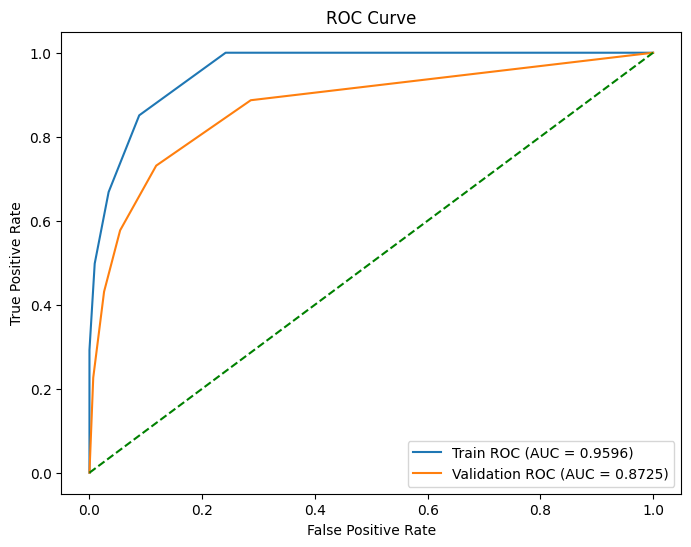

In [23]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)
auroc_train_and_val(knn, X_train, X_val, train_targets, val_targets)

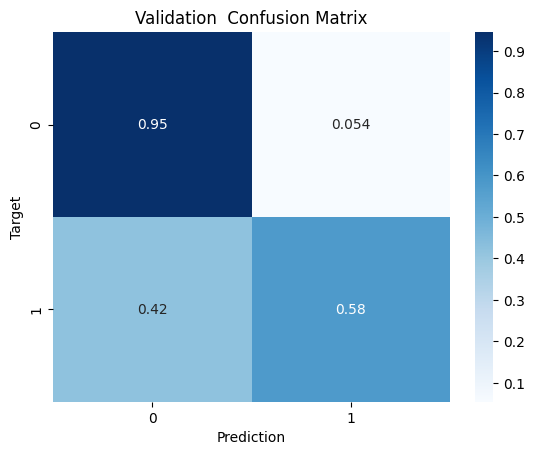

              precision  recall  f1-score   support
0.0               0.898   0.946     0.921  2390.000
1.0               0.730   0.577     0.645   610.000
accuracy          0.871   0.871     0.871     0.871
macro avg         0.814   0.761     0.783  3000.000
weighted avg      0.864   0.871     0.865  3000.000


In [24]:
predict_and_plot(knn, X_val, val_targets, name='Validation ')

**Висновки:**

Значна різниця в значеннях точності  AUROC на тренувальному та валідаційному наборах свідчить про перенавчання, така модель не підходить для використання.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Поставте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [25]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)
print('Найкраще значення параметра', knn_gs.best_params_)

Найкраще значення параметра {'n_neighbors': np.int64(7)}


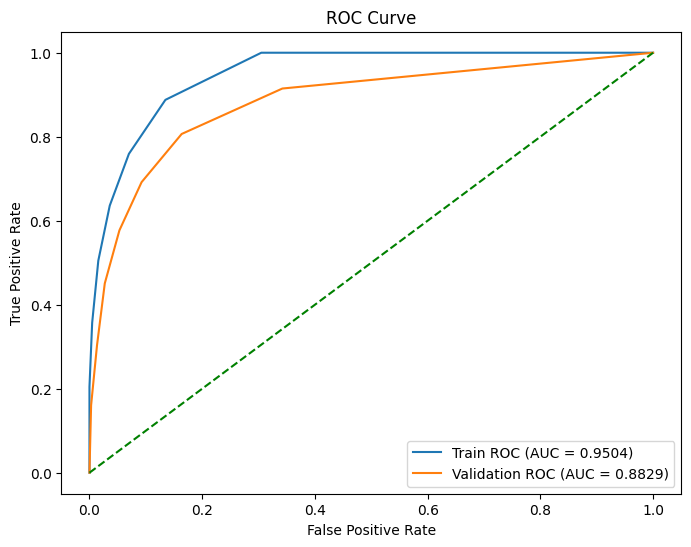

In [26]:
knn_best = knn_gs.best_estimator_
auroc_train_and_val(knn_best, X_train, X_val, train_targets, val_targets)

**Висновки:**

Показники AUROC трохи покращилися, але все досить велика різниця в значеннях точності  на тренувальному та валідаційному наборах свідчить про перенавчання, тому і ця модель не підходить для використання.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [27]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)
params_tree = {'max_depth': np.arange(1, 20),
          'max_leaf_nodes': np.arange(2, 20)}
tree_gs = GridSearchCV(tree, params_tree, cv=3, scoring='roc_auc')
tree_gs.fit(X_train, train_targets)
print('Найкращі значення параметрів', tree_gs.best_params_)

Найкращі значення параметрів {'max_depth': np.int64(6), 'max_leaf_nodes': np.int64(19)}


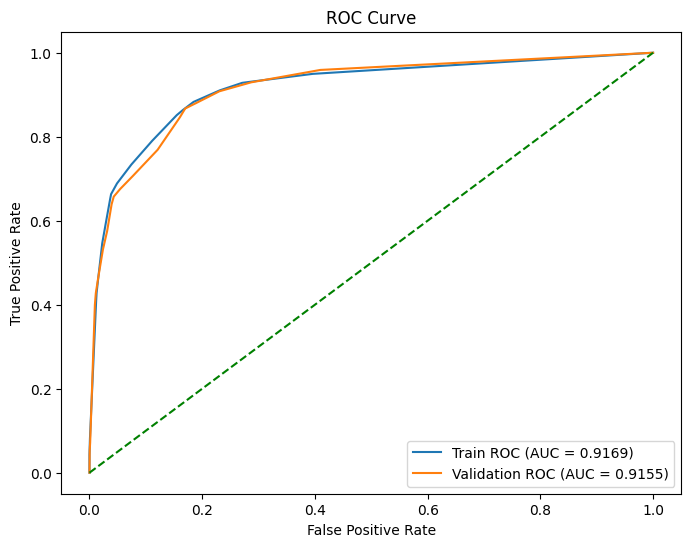

In [28]:
tree_best = tree_gs.best_estimator_
auroc_train_and_val(tree_best, X_train, X_val, train_targets, val_targets)

**Висновки:**

Показники AUROC покращилися та близькі за значеннями на тренувальному та валідаційному наборах, тому на даний момент це найкраща модель.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [39]:
from sklearn.model_selection import RandomizedSearchCV
tree = DecisionTreeClassifier(random_state = 42)
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}
random_search = RandomizedSearchCV(
    tree,
    params_dt,
    n_iter = 40,
    cv=3,
    scoring='roc_auc',
    refit=True
    )

In [40]:
%%time
tree_search = random_search.fit(X_train, train_targets)

CPU times: user 1.78 s, sys: 5.95 ms, total: 1.79 s
Wall time: 1.78 s


In [41]:
print('Найкращі значення параметрів', tree_search.best_params_)

Найкращі значення параметрів {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': np.int64(17), 'max_features': None, 'max_depth': np.int64(14), 'criterion': 'entropy'}


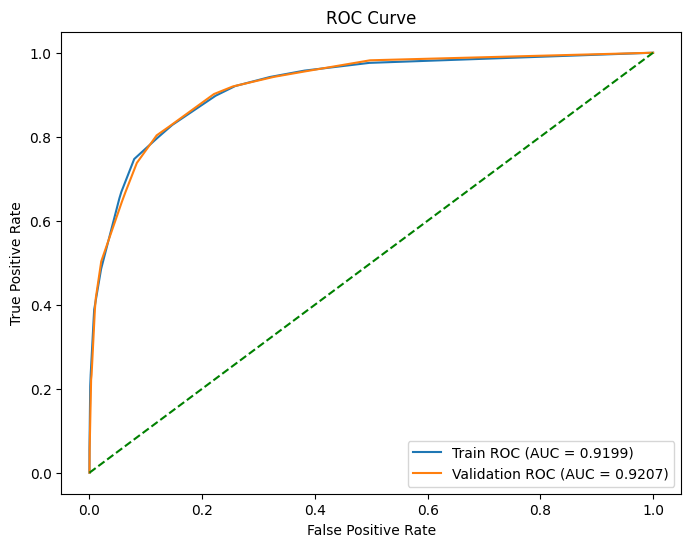

In [42]:
dt_random_search_best = tree_search.best_estimator_
auroc_train_and_val(dt_random_search_best, X_train, X_val, train_targets, val_targets)

**Висновки:**

Показники AUROC для RandomizedSearchCV трохи краще ніж для GridSearch, але для цієї моделі наявна певна випадковість. Запустивши код кілька разів, навіть з фіксованим random_state можна отримати різні значення.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [ ]:
def feature_data(df):

    df['Senior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['Active_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')

    #cat_cols = ['Geography', 'Gender', 'NumOfProducts','AgeCat']
    #onehotEncoding
    #df=pd.get_dummies(df,columns=cat_cols)
    return df

In [ ]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/Alenushka2013/Coursera/refs/heads/master/Datasets/bank-customer-churn-prediction.csv', index_col=0)

In [ ]:
raw_df1 = feature_data(raw_df)
raw_df1['Exited'] = raw_df1.pop('Exited')

In [ ]:
data = preprocess_data(raw_df1, scale_numeric=True)

X_train = data['X_train']
train_targets = data['y_train']
X_val = data['X_val']
val_targets = data['y_val']

In [ ]:
X_train.head()

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Senior,Active_by_CreditCard,Products_Per_Tenure,AgeCat,Geography_Germany,Geography_Spain,Gender_Male
id,,,,,,,,,,,,,,
7180,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,0.0,1.0,0.10,2,0.0,0.0,1.0
10393,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,0.0,0.0,0.20,2,0.0,0.0,0.0
80,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,0.0,0.30,2,1.0,0.0,1.0
3365,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,0.00,3,0.0,1.0,1.0
12236,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,0.0,1.0,0.15,1,0.0,0.0,1.0


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
def fit_poly_reg(X_train,  X_val, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_train_poly = polynomial_features.fit_transform(X_train)
    X_val_poly = polynomial_features.fit_transform(X_val)

    # # Train model and plot learning curve
    # theta, learning_curve_train, learning_curve_val = gradient_descent(X_train_poly, y_train, X_val_poly, y_val, learning_rate, n_iterations)
    # plot_learning_curve(n_iterations, learning_curve_train, learning_curve_val)

    return X_train_poly, X_val_poly #, theta

In [ ]:
X_train_poly, X_val_poly = fit_poly_reg(X_train,  X_val, 4)

In [ ]:
%%time
tree_search = search.fit(X_train, train_targets)

CPU times: user 3.78 s, sys: 13.3 ms, total: 3.79 s
Wall time: 3.79 s


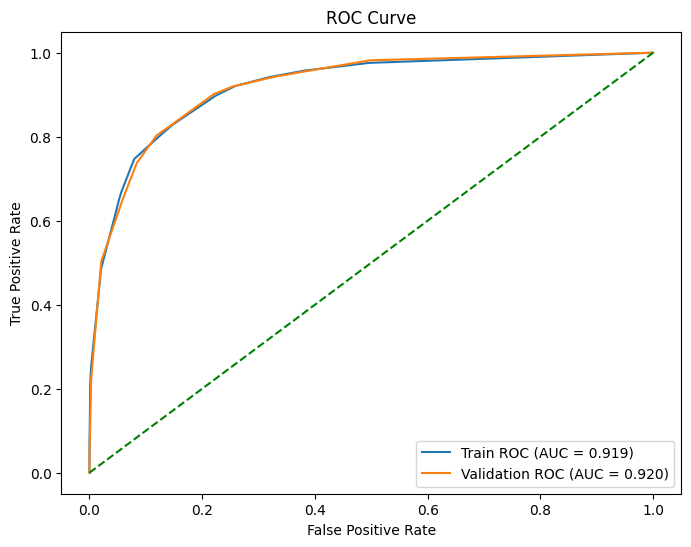

In [ ]:
tree_search_best = tree_search.best_estimator_
auroc_train_and_val(tree_search_best, X_train, X_val, train_targets, val_targets)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
import numpy as np

degree = 3
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('model', DecisionTreeClassifier(random_state=42))
])

# Додано префікс 'model__'
params_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__splitter': ['best', 'random'],
    'model__max_depth': np.arange(1, 20),
    'model__max_leaf_nodes': np.arange(2, 20),
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__max_features': [None, 'sqrt', 'log2']
}

search = RandomizedSearchCV(
    pipeline,
    params_dt,
    n_iter=100,
    cv=3,
    scoring='roc_auc',
    refit=True
)

tree_search = search.fit(X_train, train_targets)


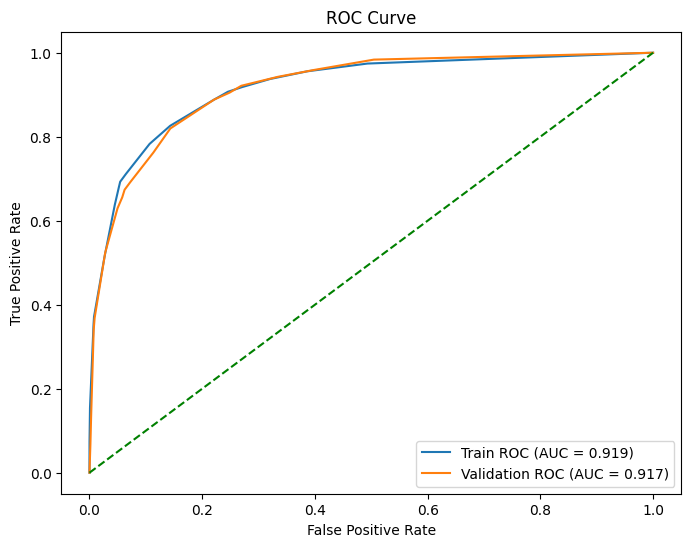

In [ ]:
tree_search_best = tree_search.best_estimator_
auroc_train_and_val(tree_search_best, X_train, X_val, train_targets, val_targets)

In [ ]:
final_model = tree_search.best_estimator_.named_steps['model']


In [ ]:
# Відтворюємо імена поліноміальних ознак
poly = tree_search.best_estimator_.named_steps['poly_features']
feature_names = poly.get_feature_names_out(input_features=X_train.columns)


In [ ]:
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


In [ ]:
print(feature_importance_df.head(20))

                                             Feature  Importance
60                 NumOfProducts Products_Per_Tenure    0.300615
1                                                Age    0.216951
4                                      NumOfProducts    0.186038
15                                             Age^2    0.080288
120                                            Age^3    0.061488
75                                  IsActiveMember^2    0.025465
25                                        Age AgeCat    0.024006
316                                        Balance^3    0.015691
61                              NumOfProducts AgeCat    0.013741
188                   Age IsActiveMember Gender_Male    0.013736
56                      NumOfProducts IsActiveMember    0.012616
122                                    Age^2 Balance    0.010682
83                        IsActiveMember Gender_Male    0.009562
212        Age Products_Per_Tenure Geography_Germany    0.008908
219                      

In [ ]:
# Отримуємо всі поліноміальні ознаки
poly = tree_search.best_estimator_.named_steps['poly_features']
feature_names = poly.get_feature_names_out(input_features=X_train.columns)

# Отримуємо важливість ознак
final_model = tree_search.best_estimator_.named_steps['model']
importances = final_model.feature_importances_

# Створюємо таблицю важливостей
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Вибираємо ознаки з ненульовою важливістю
selected_features = feature_importance_df.loc[feature_importance_df['Importance'] > 0, 'Feature'].tolist()


In [ ]:
# Перетворимо в DataFrame для зручності
X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=feature_names)

# Вибираємо тільки важливі фічі
X_train_selected = X_train_poly_df[selected_features]
X_val_selected = X_val_poly_df[selected_features]


ValueError: Shape of passed values is (12000, 120), indices imply (12000, 680)

In [ ]:
# Додано префікс 'model__'
params_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__splitter': ['best', 'random'],
    'model__max_depth': np.arange(1, 20),
    'model__max_leaf_nodes': np.arange(2, 20),
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__max_features': [None, 'sqrt', 'log2']
}

search = RandomizedSearchCV(
    pipeline,
    params_dt,
    n_iter=100,
    cv=3,
    scoring='roc_auc',
    refit=True
)

tree_search = search.fit(X_train_selected, train_targets)

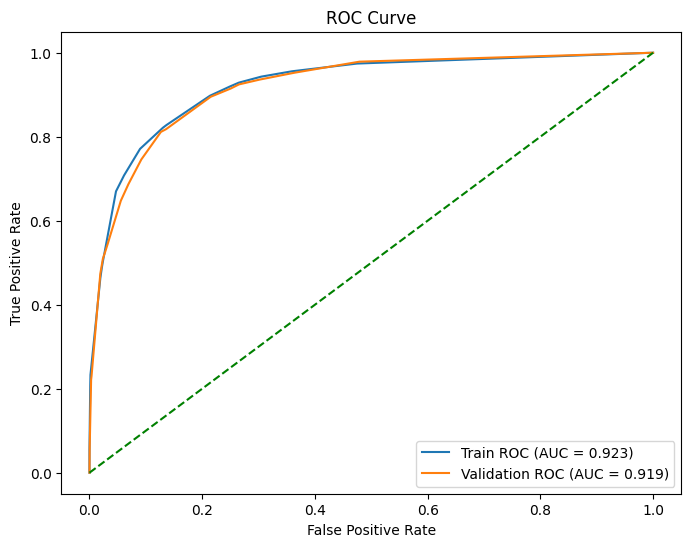

In [ ]:
tree_search_best = tree_search.best_estimator_
auroc_train_and_val(tree_search_best, X_train_selected, X_val_selected, train_targets, val_targets)